In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from queue import Queue
from scipy.stats import zscore
from concurrent.futures import ThreadPoolExecutor

In [ ]:
# Polygon API setup
api_key = ''
base_url = 'https://api.polygon.io/v2'

In [ ]:
def get_sp500_symbols():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    sp500_symbols = pd.read_html(url, header=0)[0]['Symbol'].tolist()
    return sp500_symbols

In [ ]:
symbols = get_sp500_symbols()

In [ ]:
def get_dow30_symbols():
    url = "https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average"
    dow30_symbols = pd.read_html(url, header=0)[1]['Symbol'].tolist()
    return dow30_symbols

In [ ]:
# Example usage
symbols = get_dow30_symbols()
print(symbols)

In [ ]:
import requests
import pandas as pd

def get_historical_sentiment(ticker, api_key, page=10):
    url = f"https://financialmodelingprep.com/api/v4/historical/social-sentiment?symbol={ticker}&apikey={api_key}&page={page}"
    
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        # Convert the data to a pandas DataFrame for easier handling
        df = pd.DataFrame(data)
        return df
    else:
        print(f"Failed to fetch data: {response.status_code}")
        return None

# Example usage
api_key = ""  # Replace with your FMP API key
ticker = "NVDA"
df = get_historical_sentiment(ticker, api_key)
print(df)


In [ ]:
df.head()

In [ ]:
df['stocktwitsSentiment'].plot(figsize=(15, 5), title=f"StockTwits sentiment for {ticker}")

In [ ]:
# Define the function to fetch data for a single ticker
def fetch_data_for_ticker(ticker, start_date, end_date, df):
    attempts = 0
    start = start_date
    while start < end_date:
        try:
            start_str = start.strftime('%Y-%m-%d')
            end_str = end_date.strftime('%Y-%m-%d')
            print(f"Fetching {ticker} data from {start_str} to {end_str}")

            response = requests.get(f"{base_url}/aggs/ticker/{ticker}/range/1/day/{start_str}/{end_str}?apiKey={api_key}")
            response.raise_for_status()

            data = response.json()['results']
            for day in data:
                date = datetime.fromtimestamp(day['t'] / 1000)
                df.loc[(ticker, date), 'volume'] = day['v']
                df.loc[(ticker, date), 'price'] = day['c']

            start += timedelta(days=1830)

        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            attempts += 1
            if attempts >= 2:
                print(f"Skipping {ticker} after 2 failed attempts.")
                break

In [ ]:
# Define the time period
end_date = datetime.now()
start_date = end_date - timedelta(days=15*365)

# Create an empty DataFrame with MultiIndex
columns = ['volume', 'price']
index = pd.MultiIndex(levels=[[],[]], codes=[[],[]], names=['ticker', 'timestamp'])
df = pd.DataFrame(columns=columns, index=index)

# Define a queue for thread-safe data collection
results_queue = Queue()

# Use ThreadPoolExecutor to fetch data in parallel
with ThreadPoolExecutor(max_workers=2) as executor:
    executor.map(lambda ticker: fetch_data_for_ticker(ticker, start_date, end_date, df), symbols)

# Process results from the queue and update the DataFrame
while not results_queue.empty():
    ticker, date, volume, price = results_queue.get()
    df.loc[(ticker, date), 'volume'] = volume
    df.loc[(ticker, date), 'price'] = price
    
# Save the DataFrame
df.to_csv('historical_stock_data.csv')

In [ ]:
count = 0
for symbol in df.index.get_level_values(0).unique():
    count += 1
    df.loc[symbol, 'price'].plot()
    print('Symbol:', symbol)
    if count == 5:
        break

In [1]:
import os
# change path to be in alpaca_rl_trader
os.chdir('/home/joe/Python/tradingbot/gym/alpaca_rl_trader')

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from fracdiff import fdiff

In [3]:
from data.data_loader import load_data, SplitOption

In [4]:
symbols = ['MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'GS', 'HD', 'HON',
           'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WMT']

# Get test data
data = load_data(
    ratio=0.8, split_option=SplitOption.NO_SPLIT, symbols=symbols)

/home/joe/Python/tradingbot/gym/alpaca_rl_trader


In [11]:
data['AAPL']

{'volume': array([539468356, 477115016, 573346144, ...,  48087681,  34049898,
         42672148]),
 'price': array([ 16.2007,  15.797 ,  16.3516, ..., 193.15  , 193.58  , 192.53  ]),
 'dollar_volume': array([8.73976500e+09, 7.53698591e+09, 9.37512681e+09, ...,
        9.28813559e+09, 6.59137925e+09, 8.21566865e+09]),
 'percentage_change': array([-0.00410635, -0.02491868,  0.03510793, ...,  0.000518  ,
         0.00222625, -0.00542411]),
 'log_pct_change': array([-0.0041148 , -0.0252344 ,  0.0345057 , ...,  0.00051787,
         0.00222377, -0.00543888]),
 'f_percentage_change_zscore': array([-0.0287009 , -0.14519883,  0.19080275, ..., -0.00281591,
         0.00674608, -0.03607716]),
 'f_sma_diff_10': array([-0.09134706, -0.13027593,  0.00251297, ..., -0.03733708,
        -0.02395352, -0.03169902]),
 'f_volitility_10': array([0.45010866, 0.4520817 , 0.47193487, ..., 0.07695705, 0.0494801 ,
        0.04919191]),
 'f_vmar_10': array([0.15201517, 0.13436973, 0.15896858, ..., 0.16756122, 0.1

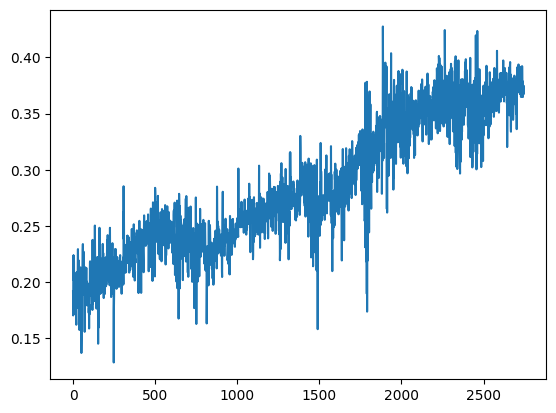

In [20]:
# plot price_data matplotlib
import matplotlib.pyplot as plt
plt.plot(data['AAPL']['f_fractional_difference_price'])

In [ ]:
historical_data = pd.read_csv('historical_stock_data.csv', index_col=[0,1], parse_dates=True)

In [ ]:
# Get test data
test_data = load_data(
    ratio=0.8, split_option=SplitOption.TEST_SPLIT, symbols=symbols)

In [ ]:
# Calculate RSI
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = (100 - (100 / (1 + rs)))/100
    return rsi

# Calculate MACD
def compute_macd(data, span1=12, span2=26, signal=9):
    exp1 = data.ewm(span=span1, adjust=False).mean()
    exp2 = data.ewm(span=span2, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_h = macd - signal_line    
    return macd_h / 5

def compute_bbands(data, window=20):
    sma = data.rolling(window=window).mean()
    std = data.rolling(window=window).std()
    upper = sma + 2 * std
    lower = sma - 2 * std
    return (upper - lower) / sma

def get_weights(d, size):
    # Vectorized computation of weights
    ks = np.arange(1, size)
    weights = np.cumprod(-(d - ks + 1) / ks)
    weights = np.insert(weights, 0, 1)
    return weights[::-1]

def fractional_differencing(series, d, threshold=1e-5):
    """
    Applies fractional differencing to a time series.

    :param series: A pandas Series of time series data
    :param d: Differencing order (fractional)
    :param threshold: Threshold below which weights are considered 0 for efficiency
    :return: A fractionally differenced series
    """
    # Compute weights
    weights = get_weights(d, len(series))
    weights = weights[np.abs(weights) > threshold]
    fd_series = series.copy()
    
    # Apply the weights to create the differenced series
    for i in range(len(weights), len(series)):
        window = series.iloc[i-len(weights):i]
        if len(window) == len(weights):
            dot_product = np.dot(weights.T, window)
            fd_series.iloc[i] = dot_product[0] if isinstance(dot_product, np.ndarray) else dot_product
    
    return fd_series[len(weights):]

def compute_sma_diff(data, window=20):
    sma = np.log(data).rolling(window=window).mean()
    return np.log(data) - sma

def calculate_vmar(volume_series, window=21):
    """
    Calculate the Volume Moving Average Ratio (VMAR).

    Parameters:
    volume_series (pandas.Series): Series containing volume data.
    window (int): Window size for moving average calculation.

    Returns:
    pandas.Series: Series containing VMAR values.
    """
    volume_ma = volume_series.rolling(window=window).mean()
    vmar = volume_series / volume_ma
    return vmar


def calculate_vcr(volume_series):
    """
    Calculate the Volume Change Rate (VCR).

    Parameters:
    volume_series (pandas.Series): Series containing volume data.

    Returns:
    pandas.Series: Series containing VCR values.
    """
    vcr = volume_series.pct_change()
    return vcr


In [ ]:
# Calculate normalized dollar volume using z-score
historical_data['dollar_volume'] = historical_data['price'] * historical_data['volume']

# Calculate percentage change
historical_data['percentage_change'] = historical_data.groupby(level=0)['price'].pct_change()
historical_data['log_pct_change'] = np.log1p(historical_data['percentage_change'])

# # Calculate RSI
# historical_data['f_rsi'] = historical_data.groupby(level=0)['price'].transform(lambda x: compute_rsi(x))

# # Calculate MACD
# historical_data['f_macd'] = historical_data.groupby(level=0)['price'].transform(lambda x: compute_macd(np.log(x))) * 200

# # Calculate Bollinger Bands
# historical_data['f_bbands'] = historical_data.groupby(level=0)['price'].transform(lambda x: compute_bbands(np.log(x))) * 10

# # compare dollar volume accrross different stocks
# historical_data['f_dollar_volume_zscore'] = historical_data.groupby(level=0)['dollar_volume'].transform(lambda x: zscore(x, nan_policy='omit')) / 10

# compare percentage change across different stocks
historical_data['f_percentage_change_zscore'] = historical_data.groupby(level=0)['percentage_change'].transform(lambda x: zscore(x, nan_policy='omit')) / 10

# Calculate simple moving average difference
historical_data['f_sma_diff_10'] = historical_data.groupby(level=0)['price'].transform(lambda x: compute_sma_diff(x, window=10)) * 3

# Calculate Volitility
historical_data['f_volitility_10'] = historical_data.groupby(level=0)['log_pct_change'].transform(lambda x: x.rolling(window=10).std()) * 10

# Calculate Volume Moving Average Ratio
historical_data['f_vmar_10'] = historical_data.groupby(level=0)['volume'].transform(lambda x: calculate_vmar(x, window=10)) / 5

In [ ]:
# # Example usage
d = 0.3  # Degree of differencing
historical_data['fractional_difference_volume'] = fdiff(np.log(historical_data['dollar_volume']), d)

In [ ]:
# Example usage
d = 0.7  # Degree of differencing
historical_data['fractional_difference_price'] = fdiff(np.log(historical_data['price']), d)

In [ ]:
historical_data

In [ ]:
x = historical_data.columns

In [ ]:
x

In [ ]:
historical_data.loc['MMM', 'f_vmar_10'][-300:].plot()

In [ ]:
historical_data.loc['MMM', 'f_sma_diff_10'][-300:].plot()

In [ ]:
count = 0
for symbol in historical_data.index.get_level_values(0).unique():
    count += 1
    historical_data.loc[symbol, 'f_volitility_10'][-3000:].plot()
    if count == 30:
        break

In [ ]:
# Get the first ticker key from the dictionary
length_of_data = len(historical_data['price']['MMM'])

In [ ]:
length_of_data

In [ ]:
# List to hold symbols to be dropped
symbols_to_drop = []

# Iterate over each symbol and check the length of its data
for symbol in historical_data.index.get_level_values(0).unique():
    if len(historical_data.loc[symbol]) < length_of_data:
        symbols_to_drop.append(symbol)
        print(f"Dropping Symbol: {symbol}, Length of data: {len(historical_data.loc[symbol])}")

In [ ]:
# Drop the symbols that do not meet the threshold
historical_data = historical_data.drop(symbols_to_drop, level='ticker')

In [ ]:
historical_data.dropna(inplace=True)
# Save the DataFrame

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter columns that start with 'f_'
f_columns = [col for col in historical_data.columns if col.startswith('f_')]

# Calculate the correlation matrix for only those columns
correlation_matrix = historical_data[f_columns].corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))  # Set the size of the figure
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()


In [ ]:
# Set a threshold for high correlation
threshold = 0.5

# Find and collect highly correlated pairs
to_drop = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            # Get the name of the feature to drop (you could also use other logic to choose which one to drop)
            colname = correlation_matrix.columns[i]
            to_drop.add(colname)

In [ ]:
to_drop

In [ ]:
historical_data.to_csv('historical_stock_data_feat.csv')

In [ ]:
historical_data.head()

In [ ]:
historical_data['log_pct_change'].unstack(level=0).cumsum().apply(np.exp).tail()

In [ ]:
for symbol in historical_data.index.get_level_values(0).unique():
    historical_data.loc[symbol,'log_pct_change'].cumsum().plot()

In [ ]:
# Step 1: Calculate cumulative log returns for each symbol
historical_data['cumulative_log_return'] = historical_data.groupby(level=0)['log_pct_change'].cumsum()

# Step 2: Get the final cumulative log return for each symbol
final_cumulative_log_returns = historical_data.groupby(level=0)['cumulative_log_return'].last()

# Step 3: Compute the mean of these final values
average_performance = final_cumulative_log_returns.mean()

# Optionally, convert this to a percentage
average_performance_percentage = np.exp(average_performance) - 1

print(f"Average Performance: {average_performance_percentage * 100:.2f}%")

2009-01-07
2023-12-15

In [ ]:
def normalize_data_log_percentage_range(data):
    # Calculate the log of the data to avoid repeating this operation
    log_data = np.log(data)

    # Find the log of min and max values
    log_min_data = np.min(log_data, axis=1, keepdims=True)
    log_max_data = np.max(log_data, axis=1, keepdims=True)

    # Calculate the log scale and middle value
    log_scale = log_max_data - log_min_data
    middle = (log_max_data + log_min_data) / 2

    # Normalize the data
    # Scale it to have mean as middle and range as log_scale
    normalized_data = (log_data - middle) / log_scale

    return normalized_data

In [ ]:
x = np.array([historical_data['price']['EQIX'].iloc[10:20]])

In [ ]:
x.shape

In [ ]:
price_data = normalize_data_log_percentage_range(x)

In [ ]:
# plot price_data matplotlib
import matplotlib.pyplot as plt
plt.plot(price_data[0])
plt.plot(price_data[1])
plt.plot(price_data[2])

In [ ]:
import math
benchmark = 201

simple_return_benchmark = (
    math.exp(abs(benchmark)) - 1) * 100 * np.sign(benchmark)

In [ ]:
simple_return_benchmark

In [ ]:
for i in range(5):
    print(i-5)

In [ ]:
x = [1,2,3,4,5,6,7,8,9,10]